In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### DEFINE DATASET

In [84]:
# DEFINE THE DATASET
sales_data = pd.read_csv('..\\data\\train.csv', index_col='ADDRESS')
sales_data = sales_data.select_dtypes(include=[np.number])
sales_data = sales_data.dropna(axis=0)

# drop irrelevant data columns by Name
sales_data = sales_data.drop(['Unnamed: 0', 'FID', 'GPID'], axis=1)

# define X and y
#X = sales_data['ave_val', 'median_val']
X = sales_data.loc[:, sales_data.columns != 'SELL_PRICE']  #independent columns

y = sales_data.SELL_PRICE   #target column i.e. price range

print(f"Dataset upload complete. Dataset comprises {len(X)} entries.")

Dataset upload complete. Dataset comprises 464 entries.


### EXPLORATION

Text(0.5, 1.0, 'Sale Price vs ave_inc')

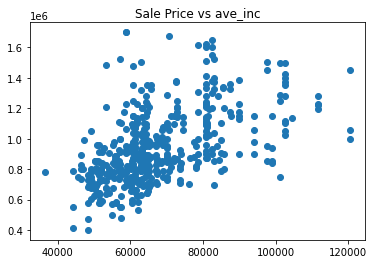

In [11]:
import matplotlib.pyplot as plt

plt.scatter(sales_data["ave_inc"],sales_data["SELL_PRICE"])
plt.title("Sale Price vs ave_inc")

In [63]:
# find corretations between the features and target
corr_matrix = sales_data.corr()
corr_matrix["SELL_PRICE"].sort_values(ascending=False)

SELL_PRICE    1.000000
median_val    0.633192
ave_val       0.612879
ave_inc       0.536629
bach_pct      0.451755
mast          0.449829
doct          0.431025
bach          0.418412
school_sco    0.389429
mast_pct      0.369604
20_24_yrs     0.355443
pop_chng_p    0.353412
owner         0.345167
highr_ed      0.340671
pop_2016      0.339449
15_64_yrs     0.333476
s_d_h         0.328731
dwl_chld      0.326559
dwellings     0.325464
commute       0.324160
0_14_yrs      0.319394
pop_2011      0.308662
65_plus_yr    0.297990
doct_pct      0.284295
land_area     0.268525
hs_size_av    0.259761
transit       0.254052
DA_ID         0.224432
0_14_pct      0.211762
owner_pct     0.195763
dwl_chld_p    0.191772
walk          0.158302
bicyc         0.138505
rnt_30pls     0.125935
mvrs_3yr_p    0.125802
rent_av       0.117939
rentr         0.071691
mvrs_1yr_p    0.070202
20_24_pct     0.027859
walk_pct      0.006752
bicyc_pct    -0.010152
shp__area    -0.040594
65_pls_pct   -0.055347
s_d_h_pct  

In [87]:
# filter the nth most correlated features into a features list
cond1 = ( abs(corr_matrix['SELL_PRICE']) > 0.3 )    # include greater than 0.2 correlation 
cond2 = ( abs(corr_matrix['SELL_PRICE']) < 1 )      # exclude SELL_PRICE (corr = 1)
filterinfDataframe = corr_matrix["SELL_PRICE"][cond1 & cond2]

filterinfDataframe = filterinfDataframe.nlargest(n=30)
features = filterinfDataframe.index.tolist()
features

['median_val',
 'ave_val',
 'ave_inc',
 'bach_pct',
 'mast',
 'doct',
 'bach',
 'school_sco',
 'mast_pct',
 '20_24_yrs',
 'pop_chng_p',
 'owner',
 'highr_ed',
 'pop_2016',
 '15_64_yrs',
 's_d_h',
 'dwl_chld',
 'dwellings',
 'commute',
 '0_14_yrs',
 'pop_2011']

In [88]:
# OPTIONAL: re-define X using only nth most correlated features
X = sales_data[features]

### PREPARE DATASET FOR MODEL

In [89]:
# split dataset into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=1)

print(f"Dataset split into {len(train_X)} training data points and {len(val_X)} validation points.")

Dataset split into 417 training data points and 47 validation points.


### DEFINE MODEL(S)

In [90]:
# Specify Model
prediction_model = DecisionTreeRegressor(random_state=1)
# Fit Model
prediction_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = prediction_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

# Using best value for max_leaf_nodes
prediction_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
prediction_model.fit(train_X, train_y)
val_predictions = prediction_model.predict(val_X)
s = prediction_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

# Define the random forest model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)
# fit your model
rf_model.fit(train_X, train_y)

preds = rf_model.predict(val_X)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_y, preds)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

Validation MAE when not specifying max_leaf_nodes: 158,321
Validation MAE for best value of max_leaf_nodes: 162,260
Validation MAE for Random Forest Model: 141,065


In [51]:
#CALCULATING PERMUTATION IMPORTANCE
import numpy as np
import eli5
from eli5.sklearn import PermutationImportance

feature_names = [i for i in sales_data.columns if sales_data[i].dtype in [np.int64]]

perm = PermutationImportance(rf_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())


Weight,Feature
0.2064 ± 0.1721,ave_val
0.1000 ± 0.0736,median_val
0.0581 ± 0.0667,bach
0.0338 ± 0.0217,bylaw_km
0.0231 ± 0.0212,bs_ave
0.0213 ± 0.0258,mvrs_3yr_p
0.0151 ± 0.0213,other_km
0.0113 ± 0.0094,ws_ave
0.0104 ± 0.0142,trees_km
0.0093 ± 0.0404,mast


In [30]:
#DEALING WITH MISSING VALUES
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_train_X = pd.DataFrame(my_imputer.fit_transform(train_X))
imputed_val_X = pd.DataFrame(my_imputer.transform(val_X))

# Imputation removed column names; put them back
imputed_train_X.columns = train_X.columns
imputed_val_X.columns = val_X.columns

# Function for comparing different approaches
def score_dataset(train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(random_state=1)
    model.fit(train_X, train_y)
    preds = model.predict(val_X)
    return mean_absolute_error(val_y, preds)

imputed_MAE = score_dataset(imputed_train_X, imputed_val_X, train_y, val_y)
print("Validation MAE from imputation: {:,.0f}".format(imputed_MAE))


Validation MAE from imputation: 127,619


In [19]:
# APPLYING CROSS-VALIDATION USING K-FOLDS
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(rf_model, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

print("Average MAE score (across experiments): {:,.0f}".format(scores.mean()))
 

MAE scores:
 [167425.00667204 153907.5374552  152368.35044205 138512.11869176
 130341.28501812]
Average MAE score (across experiments): 148,511


In [31]:
#USING XGBOOST
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, 
             early_stopping_rounds=5, 
             eval_set=[(val_X, val_y)],
             verbose=False)

predictions = my_model.predict(val_X)

print("Mean Absolute Error: " + str(mean_absolute_error(predictions, val_y)))


Mean Absolute Error: 133086.3482142857
